INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000198E96B2710>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\abc\\Desktop\\model\\time_series_prediction'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\abc\Desktop\model\time_series_prediction\model.ckpt-900

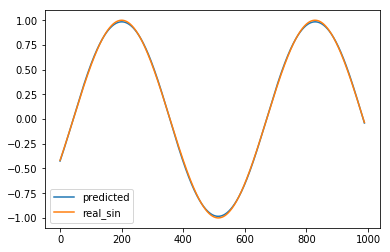

In [5]:
#时间序列预测和初次使用TFlearn
#参考https://blog.csdn.net/White_Idiot/article/details/78882856
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

# TensorFlow的高层封装TFLearn
learn = tf.contrib.learn

# 神经网络参数
HIDDEN_SIZE = 30  # LSTM隐藏节点个数
NUM_LAYERS = 2  # LSTM层数
TIMESTEPS = 10  # 循环神经网络截断长度
BATCH_SIZE = 32  # batch大小
KEEP_PROB = 1   #节点不被droupout概率  这么模型似乎不需要这个，所以设置为1
# 数据参数
TRAINING_STEPS = 3000  # 训练轮数
TRAINING_EXAMPLES = 10000  # 训练数据个数
TESTING_EXAMPLES = 1000  # 测试数据个数
SAMPLE_GAP = 0.01  # 采样间隔


def generate_data(seq):
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入，第i+TIMESTEPS项作为输出
    X = []
    y = []
    for i in range(len(seq) - TIMESTEPS - 1):
        X.append([seq[i:i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
# #所以X有len(seq) - TIMESTEPS个向量，每个向量len = TIMESTEPS

def generate_data(seq):
    X = []
    y = []
    

# LSTM结构单元
def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE)
    return lstm_cell


def lstm_model(X, y):
    # 使用多层LSTM，不能用lstm_cell*NUM_LAYERS的方法，会导致LSTM的tensor名字都一样
    num_layer_size = [HIDDEN_SIZE, HIDDEN_SIZE]
    #lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE)
    lstm_cell = [tf.nn.rnn_cell.BasicLSTMCell(num_units=size) for size in num_layer_size]
    for i in range(len(num_layer_size)):
        lstm_cell[i] = tf.contrib.rnn.DropoutWrapper(
                lstm_cell[i], output_keep_prob=KEEP_PROB)
    cell = tf.nn.rnn_cell.MultiRNNCell(
                                   lstm_cell, state_is_tuple=True)

    # 将多层LSTM结构连接成RNN网络并计算前向传播结果
    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = tf.reshape(output, [-1, HIDDEN_SIZE])

    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构
    predictions = tf.contrib.layers.fully_connected(output, 1, None)

    # 将predictions和labels调整为统一的shape
    y = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])

    # 计算损失值
    loss = tf.losses.mean_squared_error(predictions, y)

    # 创建模型优化器并得到优化步骤
    train_op = tf.contrib.layers.optimize_loss(
        loss,
        tf.train.get_global_step(),
        optimizer='Adagrad',
        learning_rate=0.1)

    return predictions, loss, train_op


# # 用sin生成训练和测试数据集
 test_start = TRAINING_EXAMPLES * SAMPLE_GAP
 test_end = (TRAINING_EXAMPLES + TESTING_EXAMPLES) * SAMPLE_GAP
# train_X, train_y = generate_data(
#     np.sin(np.linspace(0, test_start, TRAINING_EXAMPLES, dtype=np.float32)))
# test_X, test_y = generate_data(
#     np.sin(
#         np.linspace(test_start, test_end, TESTING_EXAMPLES, dtype=np.float32)))


# 建立深层循环网络模型
regressor = SKCompat(learn.Estimator(model_fn=lstm_model, model_dir=r'C:\Users\abc\Desktop\model\time_series_prediction'))
# Estimator类实例 Estimator(model_fn=None, model_dir=None, config=None, params=None, feature_engineering_fn=None)
#model_fn: 模型定义，定义了train, eval, predict的实现
# 调用fit函数训练模型
regressor.fit(train_X, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

# 使用训练好的模型对测试集进行预测
predicted = [[pred] for pred in regressor.predict(test_X)]

# 计算rmse作为评价指标
rmse = np.sqrt(((predicted - test_y)**2).mean(axis=0))
print('Mean Square Error is: %f' % (rmse[0]))

# 对预测曲线绘图，并存储到sin.jpg
fig = plt.figure()
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(test_y, label='real_sin')
plt.legend([plot_predicted, plot_test], ['predicted', 'real_sin'])
plt.show()
